 # Social Media Extremism Detection Using a Hybrid RoBERTa + Calibrated SVM Ensemble

 This notebook trains and explains a hybrid ensemble model to detect extremist
 content in social media text. The workflow:

 1. **Data loading & label encoding**
 2. **Feature engineering (SVM)**: TF–IDF n-grams
 3. **Model training**:
    - Model A: **Calibrated LinearSVC** on TF–IDF
    - Model B: **RoBERTa-base** fine-tuning with **3-seed bagging**
    - Hybrid Blend: **0.6 RoBERTa + 0.4 SVM**
 4. **Evaluation**: accuracy, F1, ROC/PR curves, calibration metrics
 5. **Explainability**:
    - SHAP for the SVM (global & local)
    - Token-level SHAP for RoBERTa (local, lightweight)
 6. **Quality control**: flagging potential label issues for manual review

In [1]:
# 0. Imports & Global Config

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from sklearn.calibration import CalibratedClassifierCV
from sklearn.svm import LinearSVC

from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    log_loss, brier_score_loss,
)

import torch
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    Trainer,
    TrainingArguments,
    DataCollatorWithPadding,
)
from datasets import Dataset

import shap

# Plot settings
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8, 5)

# Reproducibility
RANDOM_SEED = 30
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_SEED)

DATA_PATH = "extremism_data_final.csv"

# Model config (matches “Gaurav approach”)
MODEL_NAME = "roberta-base"
SEEDS = [42, 2024, 999]  # bagging seeds
EPOCHS = 3
BATCH_SIZE = 16
LR = 2e-5

# TF-IDF (matches approach)
TFIDF_NGRAM_RANGE = (1, 3)
TFIDF_MIN_DF = 2

# Ensemble settings
W_ROBERTA = 0.6
W_SVM = 0.4
VAL_THRESHOLD = 0.5

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

Device: cpu


 ## 1. Data Loading and Label Encoding

 In this section, we:
 - Load the raw dataset from `extremism_data_final.csv`
 - Preserve the original row index (`row_id`)
 - Encode labels into a binary target
 - Run a quick exploratory analysis on label distribution and text lengths

In [2]:
# 1. Load the Dataset

df = pd.read_csv(DATA_PATH)

# Keep track of original row index so we can retrieve later
df["row_id"] = df.index

print("Dataset loaded. Shape:", df.shape)
df.head()

Dataset loaded. Shape: (2777, 3)


,Original_Message,Extremism_Label,row_id
0,sixth forms should burn to the ground,EXTREMIST,0
1,whatever should burn benders to the ground,EXTREMIST,1
2,factories should burn to the ground,EXTREMIST,2
3,halal factories should burn to the ground,EXTREMIST,3
4,nhs should burn to the ground,EXTREMIST,4


Label distribution:
Extremism_Label
NON_EXTREMIST    1454
EXTREMIST        1323
Name: count, dtype: int64

Label distribution (proportions):
Extremism_Label
NON_EXTREMIST    0.523587
EXTREMIST        0.476413
Name: proportion, dtype: float64


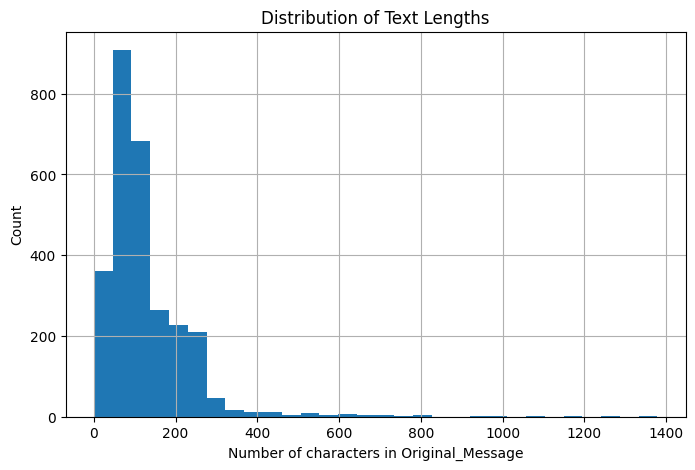

In [3]:
# 2. Encode labels and basic EDA

label_map = {"EXTREMIST": 1, "NON_EXTREMIST": 0}
df["Binary_Label"] = df["Extremism_Label"].map(label_map).astype(np.int64)
y = df["Binary_Label"].values

print("Label distribution:")
print(df["Extremism_Label"].value_counts())
print("\nLabel distribution (proportions):")
print(df["Extremism_Label"].value_counts(normalize=True))

# Quick text length distribution
texts_all = df["Original_Message"].fillna("").astype(str)
text_lengths = texts_all.str.len()

plt.hist(text_lengths, bins=30)
plt.title("Distribution of Text Lengths")
plt.xlabel("Number of characters in Original_Message")
plt.ylabel("Count")
plt.grid(True)
plt.show()

 ## 2. Feature Engineering (SVM): TF–IDF n-grams

 We construct a sparse representation of each message by:
 - Fitting a TF–IDF vectorizer on 1–3 gram tokens
 - Producing sparse feature matrices for train/validation
 - Building an aligned `feature_names` list for interpretability

In [4]:
# 3. Fit TF-IDF on the corpus

texts = texts_all.tolist()

tfidf_vectorizer = TfidfVectorizer(
    ngram_range=TFIDF_NGRAM_RANGE,
    min_df=TFIDF_MIN_DF,
    sublinear_tf=True
)

tfidf_vectorizer.fit(texts)

tfidf_feature_names = tfidf_vectorizer.get_feature_names_out().tolist()
print("Number of TF-IDF features:", len(tfidf_feature_names))

Number of TF-IDF features: 14057


 ## 3. Train/Validation Split

 We:
 - Create a stratified train/validation split on the labeled dataset
 - Keep the raw text around for interpretability
 - Prepare both TF–IDF matrices (for SVM) and tokenized datasets (for RoBERTa)

In [5]:
# 4. Train/validation split (stratified)

X_text_train, X_text_val, y_train, y_val, idx_train, idx_val = train_test_split(
    texts_all.values,
    y,
    df["row_id"].values,
    test_size=0.2,
    random_state=RANDOM_SEED,
    stratify=y,
)

print("Train size:", len(X_text_train), "Val size:", len(X_text_val))
print("Example train text:", X_text_train[0])

Train size: 2221 Val size: 556
Example train text: on me i am about to have this bitch blasted i had enough of this bullshit i hate crying because i have to hold in the urge to kill an old vagina


In [7]:
# 4b. TF-IDF matrices for SVM

X_train_tfidf = tfidf_vectorizer.transform(X_text_train)
X_val_tfidf   = tfidf_vectorizer.transform(X_text_val)

print("X_train_tfidf shape:", X_train_tfidf.shape)
print("X_val_tfidf shape:  ", X_val_tfidf.shape)

X_train_tfidf shape: (2221, 14057)
X_val_tfidf shape:   (556, 14057)


 ## 4. Model A — Calibrated LinearSVC (TF–IDF)

 We train a linear SVM on TF–IDF features and calibrate it to produce
 well-formed probabilities using `CalibratedClassifierCV`.

In [8]:
# 5. Train calibrated SVM and get validation probabilities

base_svc = LinearSVC(class_weight="balanced", C=1.0, random_state=42, dual=False)
svm = CalibratedClassifierCV(base_svc, cv=5)

svm.fit(X_train_tfidf, y_train)

svm_val_probs = svm.predict_proba(X_val_tfidf)[:, 1]
svm_val_pred  = (svm_val_probs >= VAL_THRESHOLD).astype(int)

print("SVM Validation Accuracy:", accuracy_score(y_val, svm_val_pred))
print("SVM Validation F1 (macro):", f1_score(y_val, svm_val_pred, average="macro"))

SVM Validation Accuracy: 0.8345323741007195
SVM Validation F1 (macro): 0.8343587684416409


 ## 5. Model B — RoBERTa-base Fine-tuning with 3-Seed Bagging

 We:
 - Tokenize train/validation texts
 - Fine-tune RoBERTa for 3 epochs
 - Repeat across 3 seeds and average validation probabilities

 We also capture training logs (loss curves) from one seed to visualize training dynamics.

In [9]:
# 6. Tokenization + Dataset preparation

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def tokenize_fn(batch):
    return tokenizer(batch["text"], truncation=True, max_length=128)

train_ds = Dataset.from_dict({"text": X_text_train.tolist(), "labels": y_train.tolist()})
val_ds   = Dataset.from_dict({"text": X_text_val.tolist(),   "labels": y_val.tolist()})

train_ds = train_ds.map(tokenize_fn, batched=True, remove_columns=["text"])
val_ds   = val_ds.map(tokenize_fn, batched=True, remove_columns=["text"])

train_ds.set_format("torch")
val_ds.set_format("torch")

print(train_ds)
print(val_ds)

Map:   0%|          | 0/2221 [00:00<?, ? examples/s]

Map:   0%|          | 0/556 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 2221
})
Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 556
})


In [13]:
# %%
# 7. RoBERTa training loop (3 seeds) + probability averaging

all_seed_val_probs = []
log_history_for_plots = None  # store from first seed for training dynamics plots

for j, seed in enumerate(SEEDS):
    print(f"\nTraining RoBERTa seed {seed} ({j+1}/{len(SEEDS)})...")

    model = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2).to(DEVICE)

    args = TrainingArguments(
        output_dir=f"./checkpoints_seed_{seed}",
        learning_rate=LR,
        per_device_train_batch_size=BATCH_SIZE,
        per_device_eval_batch_size=BATCH_SIZE,
        num_train_epochs=EPOCHS,
        weight_decay=0.01,
        eval_strategy="epoch",  # Changed from evaluation_strategy
        save_strategy="no",
        logging_strategy="steps",
        logging_steps=50,
        report_to="none",
        fp16=torch.cuda.is_available(),
        seed=seed,
        data_seed=seed,
    )

    trainer = Trainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        tokenizer=tokenizer,
        data_collator=data_collator,
    )

    trainer.train()

    # save log history for plots (first seed only, to mirror the “curves” section)
    if log_history_for_plots is None:
        log_history_for_plots = trainer.state.log_history

    # Predict on validation
    preds = trainer.predict(val_ds).predictions
    probs = torch.softmax(torch.tensor(preds), dim=1)[:, 1].cpu().numpy()
    all_seed_val_probs.append(probs)

    del model, trainer
    torch.cuda.empty_cache()

roberta_val_probs = np.mean(all_seed_val_probs, axis=0)
roberta_val_pred  = (roberta_val_probs >= VAL_THRESHOLD).astype(int)

print("\nRoBERTa (bagged) Validation Accuracy:", accuracy_score(y_val, roberta_val_pred))
print("RoBERTa (bagged) Validation F1 (macro):", f1_score(y_val, roberta_val_pred, average="macro"))


Training RoBERTa seed 42 (1/3)...


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/var/folders/88/x42msnrd1t33_gxpn60flc100000gn/T/ipykernel_63070/775707463.py:29: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss


RuntimeError: MPS backend out of memory (MPS allocated: 5.27 GB, other allocations: 3.79 GB, max allowed: 9.07 GB). Tried to allocate 147.26 MB on private pool. Use PYTORCH_MPS_HIGH_WATERMARK_RATIO=0.0 to disable upper limit for memory allocations (may cause system failure).

 ## 6. Hybrid Blend (0.6 RoBERTa + 0.4 SVM)

 We combine the two probability estimates:

 \[
 p_{\text{ensemble}} = 0.6 \cdot p_{\text{RoBERTa}} + 0.4 \cdot p_{\text{SVM}}
 \]

 Then we threshold at 0.5 to produce predicted labels.

In [ ]:
# 8. Ensemble probabilities and predictions

ensemble_val_probs = (W_ROBERTA * roberta_val_probs) + (W_SVM * svm_val_probs)
ensemble_val_pred  = (ensemble_val_probs >= VAL_THRESHOLD).astype(int)

acc = accuracy_score(y_val, ensemble_val_pred)
f1_macro = f1_score(y_val, ensemble_val_pred, average="macro")
f1_weighted = f1_score(y_val, ensemble_val_pred, average="weighted")

print("Ensemble metrics on validation set:")
print(f"Accuracy:      {acc:.4f}")
print(f"F1 (macro):    {f1_macro:.4f}")
print(f"F1 (weighted): {f1_weighted:.4f}")

NameError: name 'roberta_val_probs' is not defined